In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### **Dataset Preparation**

In [366]:
df = pd.read_csv('bank/bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [367]:
selected_features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

In [368]:
df_selected_features = df[selected_features]
df_selected_features.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [369]:
df_selected_features = df_selected_features.copy()
df_selected_features['y'] = np.where(df_selected_features['y'] == 'yes', 1, 0)

df_selected_features.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [370]:
from sklearn.model_selection import train_test_split

In [371]:
#splits the dataset into the training df and testing df
df_full_train, df_test = train_test_split(df_selected_features, test_size=0.2, random_state=1)

In [372]:
#splits the training dataset into the training df and validation df
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [373]:
#length of dataframes
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [374]:
#If you want your shuffled df to have sequential indices (ps: it doesn't affect the models)
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [375]:
#target variables
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [376]:
#delete the y column so you don't train with it
del df_train['y']
del df_val['y']
del df_test['y']

### **ROC AUC Feature Importance**

In [377]:
from sklearn.metrics import roc_auc_score

In [378]:
#numerical variables
df_train.dtypes[df.dtypes != 'object'].index

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [379]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

for n in numerical:
    auc = roc_auc_score(y_train, df_train[n])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[n])
    print(n, ':', auc)

age : 0.512185717527344
balance : 0.5888313805382317
day : 0.525957882383908
duration : 0.8147002759670778
campaign : 0.5714543015682159
pdays : 0.5901276247352144
previous : 0.5985653242764153


###### From the values above, it seems the variable, "duration", has the highest auc

### **Training The Model**

###### First, perform one-hot encoding:

In [380]:
from sklearn.feature_extraction import DictVectorizer

In [381]:
dv = DictVectorizer(sparse=False)

In [382]:
#turn training dataset to dictionary
train_dicts = df_train.to_dict(orient='records')

#train training dictionary
dv.fit(train_dicts)

DictVectorizer(sparse=False)

In [383]:
#transform training dictionary
X_train = dv.transform(train_dicts)

In [384]:
#turn validation dataset to dictionary
val_dicts = df_val.to_dict(orient='records')

#transform validation dictionary
X_val = dv.transform(val_dicts)

###### Then train logistic regression:

In [385]:
from sklearn.linear_model import LogisticRegression

In [386]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [387]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [388]:
#getting predictions (probability) with the validation dataset
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.02915846, 0.02367161, 0.02150487, ..., 0.23990718, 0.00222657,
       0.03858971], shape=(9042,))

In [389]:
round(roc_auc_score(y_val, y_pred), 3)

np.float64(0.901)

###### The auc of our model is 0.901

### **Precision & Recall**

In [390]:
scores = []

#thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.0, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [391]:
columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,thresholds,tp,fp,fn,tn
0,0.00,1098,7944,0,0
1,0.01,1094,7046,4,898
2,0.02,1093,5816,5,2128
3,0.03,1087,4796,11,3148
4,0.04,1073,3862,25,4082
...,...,...,...,...,...
95,0.95,39,18,1059,7926
96,0.96,30,17,1068,7927
97,0.97,25,14,1073,7930
98,0.98,20,10,1078,7934


In [392]:
#precision: fraction of positive predictions that are correct. tp/(tp + fp)
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)

In [393]:
#recall: fraction of correctly identified positive examples. tp/(tp + fn)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

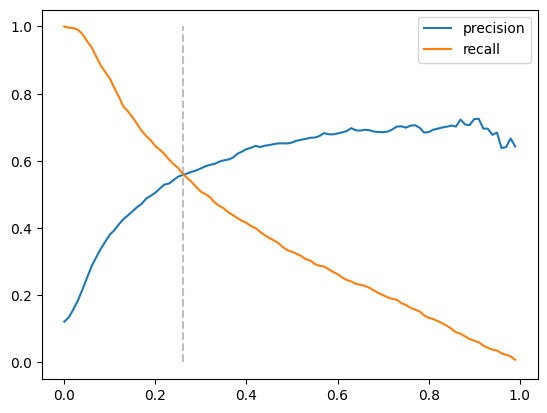

In [394]:
#graph of precision & recall
plt.plot(df_scores.thresholds, df_scores.p, label='precision')
plt.plot(df_scores.thresholds, df_scores.r, label='recall')

#intersection
plt.vlines(0.260, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

###### The precision & recall intersect at 0.260

### **F1 Score**

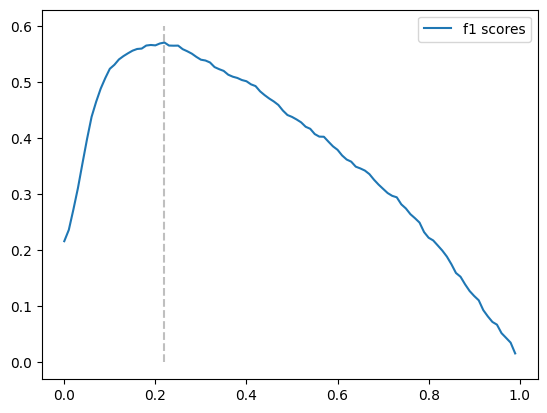

In [395]:
#computing f1 score for all the thresholds
df_scores['f1'] = 2 * ((df_scores.p * df_scores.r)/(df_scores.p + df_scores.r))

#plotting the f1 scores
plt.plot(df_scores.thresholds, df_scores.f1, label='f1 scores')

#maximal point
plt.vlines(0.220, 0, 0.6, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

###### The maximal threshold for the F1 is 0.220

### **5-Fold CV**

In [396]:
from sklearn.model_selection import KFold
from tqdm import tqdm


In [397]:
features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']

In [398]:
#defined function for training dataset
def train(df, y_train, C=1.0):
    dicts = df[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [399]:
#defined function for predictions
def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [400]:
scores = []

#5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("Mean   Std")
print('%.3f +- %3f' % (np.mean(scores), np.std(scores)))

Mean   Std
0.906 +- 0.005691


In [401]:
scores

[np.float64(0.8993733054494373),
 np.float64(0.898944421423942),
 np.float64(0.9112805043937209),
 np.float64(0.9081388806828126),
 np.float64(0.9119843456804715)]

###### The standard deviation of the auc scores is around 0.005691 across the different folds

### **Hyperparameter Tuning**

###### Different parameters of C:

In [402]:
for C in [0.000001, 0.001, 1]:

    scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=5):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s Mean=%.3f Std=+-%3f' % (C, np.mean(scores), np.std(scores)))

100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


C=1e-06 Mean=0.701 Std=+-0.009444


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


C=0.001 Mean=0.861 Std=+-0.006938


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]

C=1 Mean=0.906 Std=+-0.005691


###### The best mean score here is the one where the parameter C = 1